In [ ]:
# Reload data and apply strategy up to the point before the error
import yfinance as yf
import pandas as pd
import numpy as np

ticker_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'
stock_data = None

try:
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
except Exception as e:
    print(f"Error downloading data for {ticker_symbol}: {e}")

if stock_data is None or stock_data.empty or len(stock_data) < 100:
    print(f"Warning: Data for {ticker_symbol} is empty or insufficient for analysis.")
else:
    short_window = 40
    long_window = 100

    if 'Close' in stock_data.columns:
        stock_data['Short_MA'] = stock_data['Close'].rolling(window=short_window).mean()
        stock_data['Long_MA'] = stock_data['Close'].rolling(window=long_window).mean()

        # Drop NaNs from the entire DataFrame including the new MA columns
        initial_rows_full_dropna = len(stock_data)
        stock_data.dropna(inplace=True)
        if len(stock_data) < initial_rows_full_dropna:
            print(f"Dropped {initial_rows_full_dropna - len(stock_data)} rows due to NaN values using dropna() without subset after MA calculation.")

        if stock_data.empty:
            print("Error: DataFrame is empty after initial dropna.")
        else:
            stock_data['Signal'] = 0
            if len(stock_data.index) >= long_window:
                 if isinstance(stock_data.columns, pd.MultiIndex):
                    try:
                        stock_data.loc[stock_data.index[long_window-1:], 'Signal'] = np.where(
                            stock_data[('Short_MA', '')][long_window-1:] > stock_data[('Long_MA', '')][long_window-1:], 1, 0
                        )
                    except KeyError as e:
                         print(f"KeyError accessing MultiIndex columns for signal generation: {e}")
                         stock_data = pd.DataFrame() # Clear data to prevent further errors
                 else:
                     # Fallback for flat index (shouldn't be needed based on MultiIndex)
                     try:
                         stock_data.loc[stock_data.index[long_window-1:], 'Signal'] = np.where(
                            stock_data['Short_MA'][long_window-1:] > stock_data['Long_MA'][long_window-1:], 1, 0
                        )
                     except KeyError as e:
                         print(f"KeyError accessing flat index columns for signal generation: {e}")
                         stock_data = pd.DataFrame() # Clear data to prevent further errors

            if 'Signal' in stock_data.columns:
                 stock_data['Position'] = stock_data['Signal'].diff()

                 initial_capital = 100000
                 stock_data['Daily_Return'] = 0.0

                 if ('Close', 'AAPL') in stock_data.columns:
                     stock_data['Asset_Daily_Return'] = stock_data[('Close', 'AAPL')].pct_change()
                     if 'Position' in stock_data.columns:
                         # Calculate Daily_Return before the problematic dropna
                         stock_data['Daily_Return'] = stock_data['Asset_Daily_Return'] * stock_data['Position'].shift(1)

                         # --- Point just before the previous KeyError ---
                         print("Columns before dropna(['Daily_Return']):", stock_data.columns)
                         print("Head before dropna(['Daily_Return']):\n", stock_data.head())
                         # --- End point before previous KeyError ---

                         # The problematic dropna call
                         # stock_data.dropna(subset=['Daily_Return'], inplace=True) # This caused the error

                         # Continue from here, skipping the problematic dropna for now
                         # The NaN in 'Daily_Return' is only in the first row after the shift,
                         # so manual filtering might be a workaround for the KeyError.
                         if 'Daily_Return' in stock_data.columns:
                            # Manual filtering instead of dropna(subset=['Daily_Return'])
                            stock_data = stock_data.loc[stock_data['Daily_Return'].notna()].copy() # Use .copy() to avoid SettingWithCopyWarning
                            if not stock_data.empty:
                                 stock_data['Cumulative_Return'] = (1 + stock_data['Daily_Return']).cumprod()
                                 stock_data['Cumulative_Value'] = initial_capital * stock_data['Cumulative_Return']

                                 # Evaluate results - only if data remains
                                 if len(stock_data) > 0:
                                     total_return = (stock_data['Cumulative_Return'].iloc[-1] - 1) * 100
                                     print(f"Total Return: {total_return:.2f}%")

                                     running_max = stock_data['Cumulative_Value'].cummax()
                                     drawdown = (stock_data['Cumulative_Value'] - running_max) / running_max
                                     max_drawdown = drawdown.min() * 100
                                     print(f"Maximum Drawdown: {max_drawdown:.2f}%")

                                     winning_days = (stock_data['Daily_Return'] > 0).sum()
                                     total_days = len(stock_data)
                                     percentage_winning_days = (winning_days / total_days) * 100
                                     print(f"Percentage of Winning Days: {percentage_winning_days:.2f}%")

                                     mean_daily_return = stock_data['Daily_Return'].mean()
                                     std_daily_return = stock_data['Daily_Return'].std()

                                     if std_daily_return != 0:
                                         sharpe_ratio = (mean_daily_return / std_daily_return) * np.sqrt(252)
                                         print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
                                     else:
                                         print("Sharpe Ratio: Cannot calculate (standard deviation of daily returns is zero)")
                                 else:
                                     print("Error: No data remaining after manual filtering for performance metrics.")
                            else:
                                print("Error: DataFrame is empty after manual filtering for NaN 'Daily_Return'.")
                         else:
                            print("Error: 'Daily_Return' column not found before manual filtering.")
                     else:
                         print("Error: 'Position' column not found after signal generation.")
                 else:
                     print("Error: ('Close', 'AAPL') column not found for asset daily return calculation.")
            else:
                print("Error: 'Signal' column not created successfully.")
            # No else needed here for MultiIndex/flat index error, as it would have printed earlier

    else:
        print("Error: 'Close' column not found in downloaded data.")


/tmp/ipython-input-1325011582.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Dropped 99 rows due to NaN values using dropna() without subset after MA calculation.
Columns before dropna(['Daily_Return']): MultiIndex([(             'Close', 'AAPL'),
            (              'High', 'AAPL'),
            (               'Low', 'AAPL'),
            (              'Open', 'AAPL'),
            (            'Volume', 'AAPL'),
            (          'Short_MA',     ''),
            (           'Long_MA',     ''),
            (            'Signal',     ''),
            (          'Position',     ''),
            (      'Daily_Return',     ''),
            ('Asset_Daily_Return',     '')],
           names=['Price', 'Ticker'])
Head before dropna(['Daily_Return']):
 Price           Close       High        Low       Open     Volume   Short_MA  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL              
Date                                                                           
2020-05-26  76.970879  78.795934  76.914982  78.616103  125522000  69.5

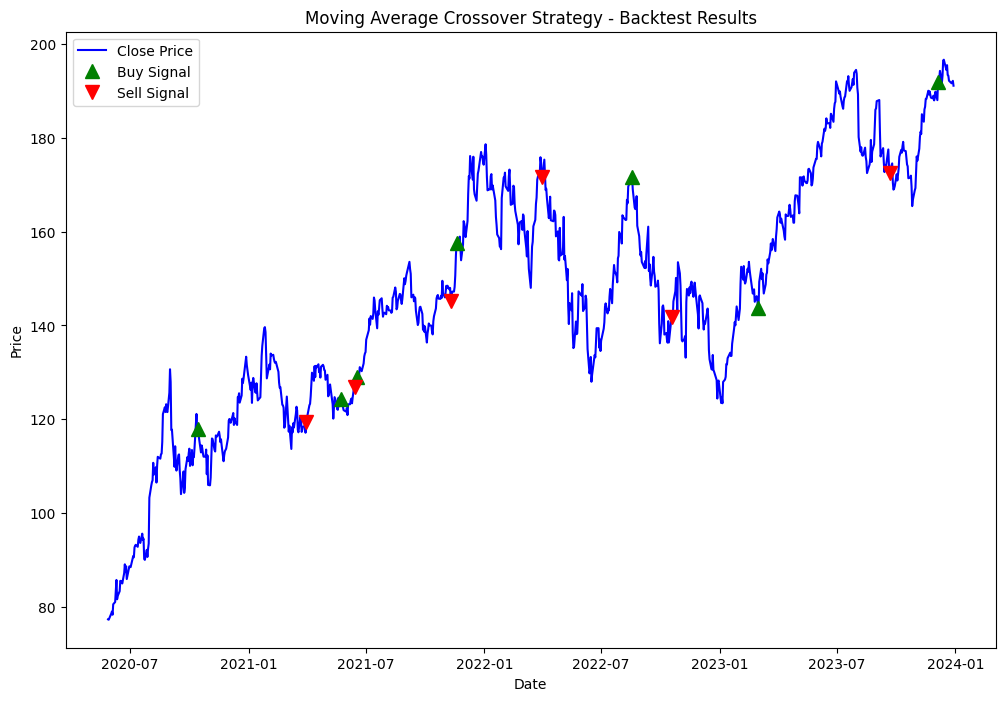

In [ ]:
import matplotlib.pyplot as plt

# 2. Create a new plot with a figure size of 12x8 inches.
fig, ax = plt.subplots(figsize=(12, 8))

# 3. Plot the 'Close' price data from the stock_data DataFrame.
ax.plot(stock_data.index, stock_data[('Close', 'AAPL')], label='Close Price', color='blue')

# 4. Add markers for buy signals (when 'Position' changes from 0 to 1).
# Buy signal is indicated by stock_data['Position'] == 1 and stock_data['Position'].shift(1) == 0
buy_signals = stock_data[stock_data['Position'] == 1]
ax.plot(buy_signals.index, buy_signals[('Close', 'AAPL')], '^', markersize=10, color='g', lw=0, label='Buy Signal')

# 5. Add markers for sell signals (when 'Position' changes from 1 to 0).
# Sell signal is indicated by stock_data['Position'] == -1
sell_signals = stock_data[stock_data['Position'] == -1]
ax.plot(sell_signals.index, sell_signals[('Close', 'AAPL')], 'v', markersize=10, color='r', lw=0, label='Sell Signal')


# 6. Label the x-axis with 'Date' and the y-axis with 'Price'.
ax.set_xlabel('Date')
ax.set_ylabel('Price')

# 7. Add a title to the plot.
ax.set_title("Moving Average Crossover Strategy - Backtest Results")

# 8. Add a legend to distinguish the close price line and buy/sell signals.
ax.legend()

# 9. Display the plot.
plt.show()